This notebook is based on scikit-bio's progressive multiple sequence alignment [recipe](https://github.com/biocore/scikit-bio-cookbook/blob/master/Progressive%20multiple%20sequence%20alignment.ipynb).

In [5]:
cd trimmed-150nts/

/Users/yoshikivazquezbaeza/Documents/PDF/KnightLaboratory/HastyWater/trimmed-150nts


In [210]:
%matplotlib inline
import qiime2 as q2, pandas as pd, seaborn as sns, numpy as np
from biom import Table
import matplotlib.pylab as plt

import qiime2.plugins.feature_table as FT

def load_mf(fn, index='#SampleID'):
    _df = pd.read_csv(fn, sep='\t', dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

## Create the needed files for the alignment

In [13]:
ft = q2.Artifact.load('feature-table.acinetos.qza').view(pd.DataFrame)

In [14]:
tax = q2.Artifact.load('taxonomy.qza').view(pd.DataFrame)

Create a FASTA file identified by the total number of sequences in the entire dataset. I added a check just in case the assumption that the number of sequences can't function as a unique identifer.

In [36]:
with open('acinetobacters.fasta', 'w') as f:
    seen = set([])
    
    for seq, counts in ft.sum().sort_values(ascending=False).iteritems():
        if counts > 400:
            if counts in seen:
                raise ValueError('The ids are not unique! Create hashes or something')
                
            f.write('>%d\n' % counts)
            f.write('%s\n' % seq)
            
            seen.add(counts)

Nineteen sequences total.

In [26]:
!wc -l acinetobacters.fasta

      38 acinetobacters.fasta


In [39]:
with open('acinetobacters.taxonomies.tsv', 'w') as f:
    for seq, counts in ft.sum().sort_values(ascending=False).iteritems():
        if counts > 400:
            
            # get the full taxonomic name and just save what type of
            # acinetobacter it is that we deal with ... all should be
            # of family Moraxellaceae
            name = tax.loc[seq].Taxon
            name = name.split('Moraxellaceae; ')[1]
            
            f.write('%d\t%s\n' % (counts, name))

In [30]:
cat acinetobacters.taxonomies.tsv

422060.0	g__Acinetobacter; s__rhizosphaerae
291443.0	g__Acinetobacter; s__rhizosphaerae
252974.0	g__Acinetobacter; s__rhizosphaerae
230285.0	g__Acinetobacter; s__rhizosphaerae
207584.0	g__Acinetobacter; s__rhizosphaerae
154901.0	g__Acinetobacter
146067.0	g__Acinetobacter; s__rhizosphaerae
99102.0	g__Acinetobacter
94808.0	g__Acinetobacter; s__rhizosphaerae
78723.0	g__Acinetobacter
45526.0	g__Acinetobacter
24664.0	g__Acinetobacter; s__rhizosphaerae
22381.0	g__Acinetobacter
13516.0	g__Acinetobacter
3130.0	g__Acinetobacter
2332.0	g__Acinetobacter
1515.0	g__Acinetobacter
1128.0	g__Acinetobacter
889.0	g__Acinetobacter; s__


In [41]:
import collections
import io

import skbio.io
from skbio import DNA

slice_length = 150
display_tax_levels = 2

fasta = 'acinetobacters.fasta'
taxonomies = open('acinetobacters.taxonomies.tsv').readlines()
t = {}
for e in taxonomies:
    fields = e.rstrip('\n').split('\t')
    t[fields[0]] = fields[1]
taxonomies = t

sequences = collections.OrderedDict()
for seq in skbio.io.read(fasta, format='fasta'):
    seq_id = seq.metadata['id']
    seq_tax = taxonomies[seq.metadata['id']] # ' '.join(taxonomies[seq.metadata['id']].split('; ')[:display_tax_levels])
    seq_id = '%s (%s)' % (seq_tax, seq.metadata['id']) 
    sequences[seq_id] = DNA(sequence=seq[:slice_length], metadata={'id': seq_id})
print(len(sequences))

19


In [42]:
next(iter(sequences.values()))

DNA
---------------------------------------------------------------------
Metadata:
    'id': 'g__Acinetobacter; s__rhizosphaerae (422060)'
Stats:
    length: 150
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 51.33%
---------------------------------------------------------------------
0   CCTACGGGGG GCAGCAGTGG GGAATATTGG ACAATGGGCG CAAGCCTGAT CCAGCCATGC
60  CGCGTGTGTG AAGAAGGCCT TATGGTTGTA AAGCACTTTA AGCGAGGAGG AGGCTACTTT
120 AGTTAATACC TAGAGATAGT GGACGTTACT

## Multiple sequence alignment

We can then compute kmers distances between the sequences.

In [43]:
import functools

from skbio.sequence.distance import kmer_distance
from skbio import DistanceMatrix

kmer_distances = DistanceMatrix.from_iterable(sequences.values(), metric=functools.partial(kmer_distance, k=8), key='id')

### Build a guide tree.

In [45]:
from scipy.cluster.hierarchy import average, dendrogram, to_tree

/Users/yoshikivazquezbaeza/miniconda/envs/qiime2-2018.4/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


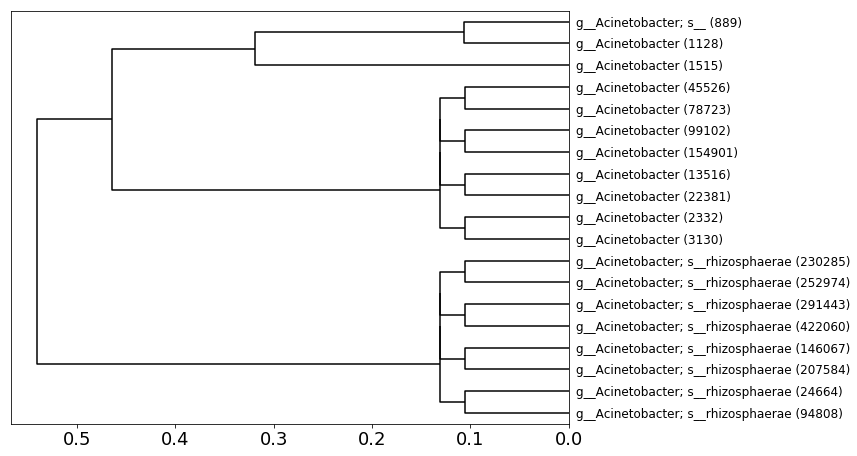

In [198]:
guide_lm = average(kmer_distances.condensed_form())
def format_dendrogram(tip_count):
    import matplotlib
    import matplotlib.pylab as plt
    ax = plt.gca()
    fig = plt.gcf()
    height = tip_count * 0.4
    if height < 3:
        height = 3
    fig.set_size_inches(10, height)
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 18}

    matplotlib.rc('font', **font)
    return ax

format_dendrogram(kmer_distances.shape[0])


guide_d = dendrogram(guide_lm, labels=kmer_distances.ids, orientation='left', 
                     link_color_func=lambda x: 'black', )

In [47]:
from skbio import TreeNode

In [48]:
guide_tree = TreeNode.from_linkage_matrix(guide_lm, kmer_distances.ids)

And then do progressive alignment

In [49]:
from skbio.alignment import global_pairwise_align_nucleotide

def progressive_msa(query_sequences, guide_tree, pairwise_aligner=global_pairwise_align_nucleotide):
    # we need a parallel implementation of this functionality, and a Cython/C global aligner that can handle 
    # alignment of alignments. If done right, it could have a big impact on the field. Contact 
    # gregcaporaso@gmail.com if you have any interest in working on this. 
    c1, c2 = guide_tree.children
    if c1.is_tip():
        c1_aln = query_sequences[c1.name]
    else:
        c1_aln = progressive_msa(query_sequences, c1, pairwise_aligner)

    if c2.is_tip():
        c2_aln = query_sequences[c2.name]
    else:
        c2_aln = progressive_msa(query_sequences, c2, pairwise_aligner)
        
    return pairwise_aligner(c1_aln, c2_aln)[0]

In [50]:
msa = progressive_msa(sequences, guide_tree)

/Users/yoshikivazquezbaeza/git_sw/scikit-bio/skbio/alignment/_pairwise.py:599: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  "to track progress on this).", EfficiencyWarning)


We can next build a tree from this multiple sequence alignment. To do that, we'll first compute the Hamming distances between the sequences, and then pass the resulting ``DistanceMatrix`` to the ``average`` function (for now this is a UPGMA tree, in the future, we'll update to use skbio's neighbor joining function).

In [51]:
from skbio.sequence.distance import hamming
msa_distances = DistanceMatrix.from_iterable(msa, metric=hamming, key='id')

/Users/yoshikivazquezbaeza/miniconda/envs/qiime2-2018.4/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


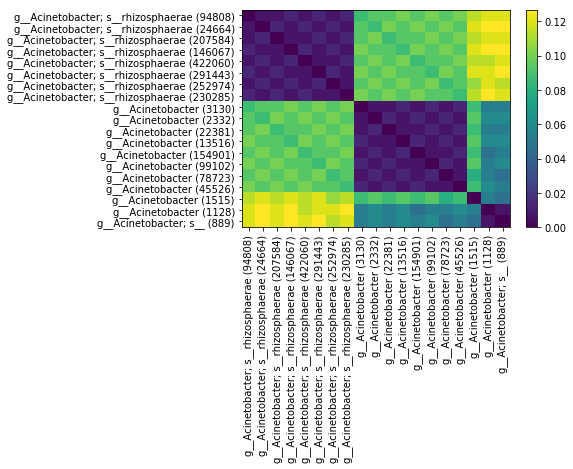

In [192]:
msa_distances

/Users/yoshikivazquezbaeza/miniconda/envs/qiime2-2018.4/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


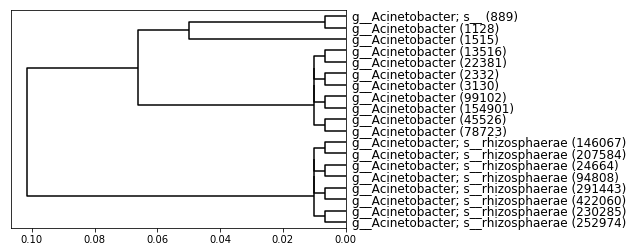

In [169]:
lm = average(msa_distances.condensed_form())
d = dendrogram(lm, labels=msa_distances.ids, orientation='left', 
               link_color_func=lambda x: 'black')

# Looking at the abundance data in the context of the MSA.

In [59]:
mf = load_mf('mapping-file.alpha.tsv')

In [111]:
most_abundant = ft[(ft.sum()[ft.sum() > 400]).index].copy()

In [112]:
most_abundant['day'] = pd.to_numeric(mf['day']).copy()
most_abundant['Description'] = mf['Description'].copy()

most_abundant.sort_values(by=['day', 'Description'], ascending=True, inplace=True)

### Figure out what things we can use as a reference

With the MSA, we can now look at the sequence-wise ordered heatmap of the abundances. This should help us identify the features that are correlated in abundance and similar in terms of the seqeuences themselves. This approach was a suggestion by [@jongsanders](https://twitter.com/jongsanders).

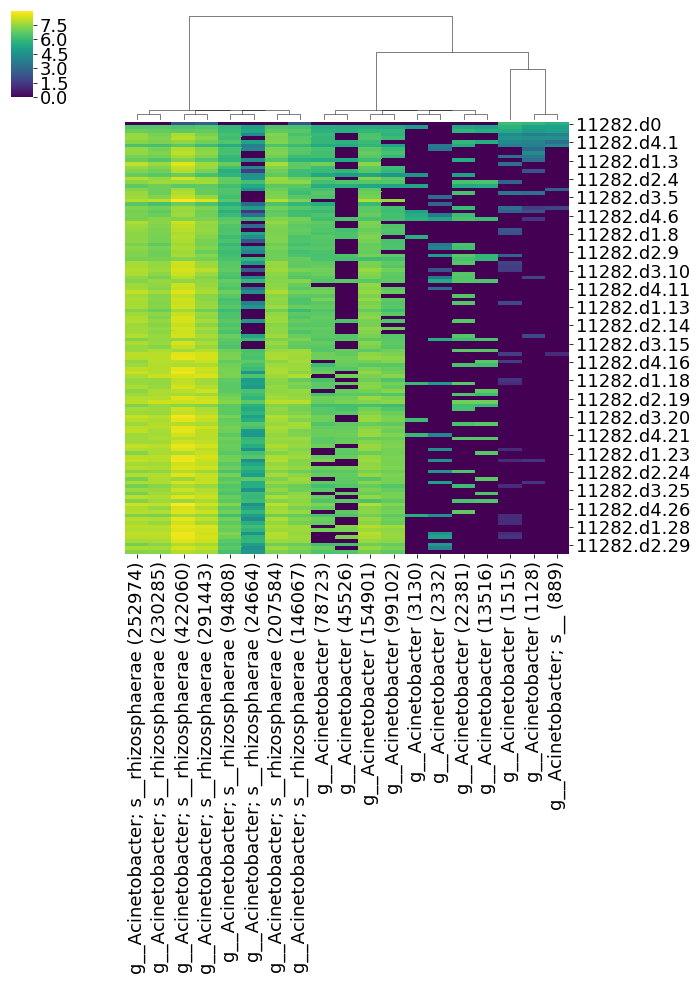

In [201]:
X = most_abundant.drop(['Description', 'day'], axis=1)

ordered_sequences = [str(sequences[s]) for s in msa_distances.ids]
X = X[ordered_sequences]
X.columns = list(msa_distances.ids)

g = sns.clustermap(np.log(X + 1), row_cluster=False, col_cluster=True, cmap='viridis', col_linkage=lm)

g.savefig('msa-clustered-abundance-heatmap.png', dpi=326)

From the plot above:

- The most abundant and constant sequences are all very similar (clusters on the left).
- There's a few features that are likely misclassified, see the three features on the far right. Those features are only present at the beginning of the time series.

As a supplement, lets also look at how correlated these features are.

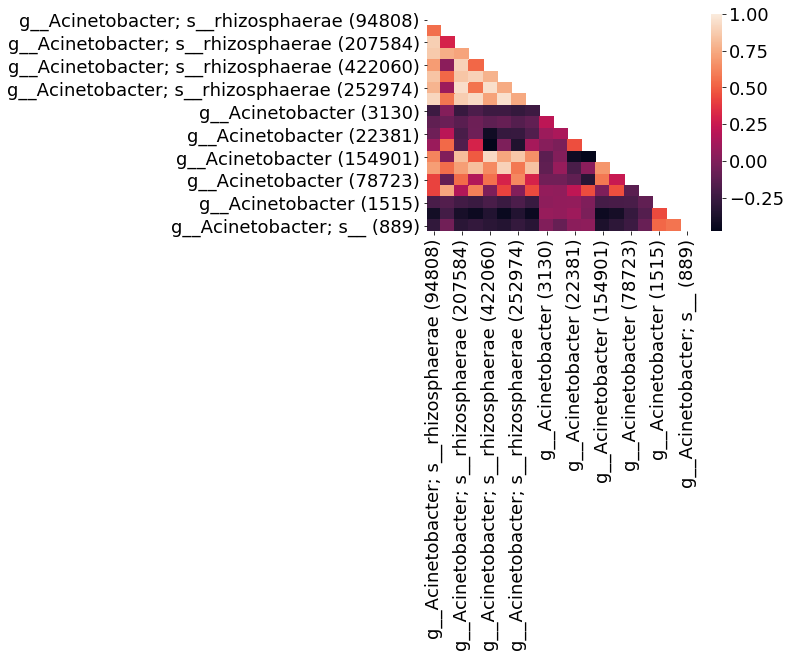

In [202]:
corr = np.log(X + 1).corr('spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, xticklabels=)

The correlation matrix above shows that indeed the members of the two major clusters are highly correlated with each other. The third (smallest) cluster is not at all and is also further away in terms of the sequence similarity.

**We'll use the two major clusters as the normalization features, and remove the third cluster since we know it is misclassified and would be *odd* to see acinetobacter in the analysis.**

To get those two groups we can grab all the features classified as acinetobacter that have more than 2,000 sequences total and use that group as the normalization vector, and remove the rest from the final table.

In [213]:
FT.actions.filter_features(
    table=q2.Artifact.load('feature-table.acinetos.qza'),
    min_frequency=2000
).filtered_table.save('feature-table.acinetos.normalization-features.qza')

'feature-table.acinetos.normalization-features.qza'

In [214]:
FT.actions.filter_features(
    table=q2.Artifact.load('feature-table.acinetos.qza'),
    max_frequency=2000
).filtered_table.save('feature-table.acinetos.discardable-features.qza')

'feature-table.acinetos.discardable-features.qza'